In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr

import seaborn as sns
import utils
import learn
import monte_carlo_permutations as mcps


from sklearn.metrics import r2_score

from typing import List, Tuple


# Introduction

Here we develop a simple model that forecasts bitcoin returns. The model has two parameters - the look-ahead value N (prediction horizon) and number of PCA components. The model uses tecnical indicators such as the simple moving average, RSI and Bollinger bands. These indicators are widely used by traders to respond to market conditions. For instance, some traders may use a short-period RSI to scalp small price movements, while others may rely on longer periods to identify divergences. Given their widespread use across diverse strategies, these indicators may reflect collective behavioural patterns of market participants. This model aims to identify and exploit such patterns by learning relationships between indicator configurations and future returns.

Similar approaches can be seen in the following papers:
 * [Predicting bitcoin returns using high-dimensional technical indicators](https://www.sciencedirect.com/science/article/pii/S2405918818300928?utm_source=chatgpt.com)
 * [Intraday Functional PCA Forecasting of Cryptocurrency Returns](https://arxiv.org/pdf/2505.20508)
 * [Technical trading and cryptocurrencie](https://link.springer.com/article/10.1007/s10479-019-03357-1?utm_source=chatgpt.com)
 * [Time-series forecasting of Bitcoin prices using high-dimensional features: a machine learning approach](https://pmc.ncbi.nlm.nih.gov/articles/PMC7334635/pdf/521_2020_Article_5129.pdf)



# Methodology

## Study outline

The following strategy is employed when developping and assesing the model perfromance:

1. Assess in sample performance.
2. In sample Monte-Carlo permutation test.
3. Asses Walk Forward performance.
4. Walk forward Monte-Carlo permutation test. 

Step 1. allows us to see if the model is worth developing. Step 2 is used to test the model - does the model hold any predictive power in sample? If so, we can proceed to step 3, which allows us to explore the model behaviour under realistic conditions. Finally, step 4 will reveal if the model has any predictive power out of sample.

To further assess the model performance, we will use the Sharpe ratio and the profit factor as objective functions.

## Model outline

The model can be described as follows:

 * Compute simple moving averages for 10-100 lookback windows.
 * Compute RSI for 2-72 lookback windows.
 * Instead of using Bollinger bands, we simply compute the standard deviations of the closing price. As both the upper and the lower Bollinger band are computed by adding/subtracting these to/from the SMAs, this removes some unnecessary correlations in our feature vectors. 

 Next, the feature vectors are z-standardised, after which PCA is applied. The number of PCA components to use is model parameter that can be optimised when we walk forward the model. This PCA embedding is then used to forecast the log returns N hours ahead, which is our second model parameter that can be optimised.

To begin, we load hourly bitcoin data. Use the get_data.py module to download the dataset, which will fetch hourly bitcoin data from January 1st, 2020 to July 4th, 2025:

```sh
python get_data.py
```

### 1. In-Sample performance

In [ ]:
df = pd.read_csv("data/BTCUSDT_1h_1_Jan_2023_04_July_2025.csv")

df["time"] = pd.to_datetime(df["timestamp"])

df["log_ret"] = np.log(df["close"]).diff()

index_windwos_rsi =  np.arange(2, 24 + 1)
index_windwos_mas = np.arange(10,101,10)


df = utils.add_rsis(df, index_windwos_rsi)
df = utils.add_mas(df, index_windwos_mas)


df = df.dropna().reset_index(drop=True)

df.index = df["time"].values


We added RSI, moving averages.with various window lengths (2-72 hours, 1 hour steps, for RSI, 10-100, 10 hours steps for moving averages and Bollinged bands). Let us now explore the in-sample perfrormance of the model. We apply PCA (after standardising) and optimise for the look ahead parameter N and number of components:

In [ ]:

in_sample_period_end = pd.DateOffset(months=3)
in_sample_period_mask = (df.index < df.index[0] + in_sample_period_end) 

df_in_sample = df.loc[in_sample_period_mask].copy()

look_ahead_vals = np.arange(2,11)
npca_vals = np.arange(2,9)
lookback_vals = [30]
vali_split = 0.5
cost = 0.001

15


<Axes: >

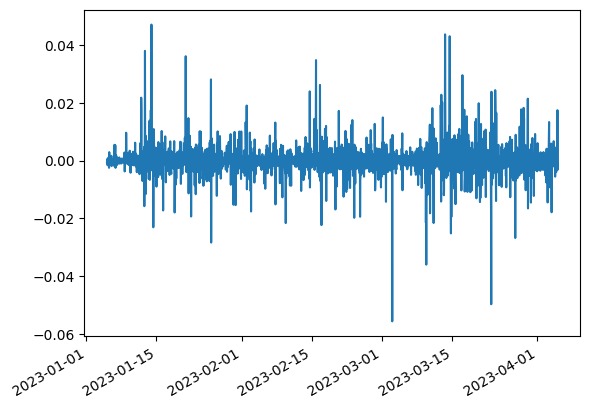

In [4]:
df_in_sample["log_ret"].plot()

In [6]:
from joblib import Parallel, delayed
from itertools import product



def run_single_optimisation(df, N, npca, time_val):
    try:
        _pca, _model, _scaler, _y_pred, _y, signal, up_q, low_q, subsignals, subqs, logrs = (
            learn.train_model_on_subwindows(
                df,
                N=N,
                npca=npca,
                window_size=24 * time_val,
                vali_split=vali_split,
            )
        )

        sharpe_distro = []
        pr_distro = []

        for sig, logr in zip (subsignals, logrs):
            sig = pd.Series(sig)
            _, _pr, _sharpe = utils.compute_returns(sig, logr, cost=cost)
            sharpe_distro.append(_sharpe * np.sqrt(365 * 24))
            pr_distro.append(_pr)


        strat_ret, pr, sharpe = utils.compute_returns(signal, df["log_ret"], cost=cost)

        return {
            "sharpe_validate": sharpe * np.sqrt(365 * 24),
            "profit_ratio_validate": pr,
            "sharpe_distro": sharpe_distro,
            "pr_distro": pr_distro,
            "model_outputs": (_pca, _model, _scaler, _y_pred, _y),
            "model_signals": (signal, up_q, low_q),
            "model_params_list": (N, npca, time_val),
            "strategy_returns": strat_ret,
            "subsigs": subsignals,
            "subqs": subqs,
        }

    except Exception as e:
        print(f"Failed for N={N}, npca={npca}, time_val={time_val} — {e}")
        return None
    
param_combinations = list(product(look_ahead_vals, npca_vals, lookback_vals))

results = Parallel(n_jobs=-1)(  
    delayed(run_single_optimisation)(df_in_sample, N, npca, time_val)
    for N, npca, time_val in param_combinations
)


optimisation_dict = {
    "sharpe_validate": [],
    "profit_ratio_validate": [],
    "strategy_returns": [],
    "model_outputs": [],
    "model_signals": [],
    "model_params_list": [],
    "sharpe_distro": [],
    "pr_distro": [],
    "subsigs": [],
    "subqs": [],
}


for res in results:
    if res is not None:
        for k in optimisation_dict:
            optimisation_dict[k].append(res[k])

        
prs_pos = np.array([np.mean(pr) for pr in optimisation_dict["pr_distro"]])


best_idx_pos = int(np.argmax(prs_pos))


pca, model, scaler, y_pred, y = optimisation_dict["model_outputs"][best_idx_pos]
best_signal, _, _ = optimisation_dict["model_signals"][best_idx_pos]

best_params = optimisation_dict["model_params_list"][best_idx_pos]
N_best, npca_best, lookback = best_params

print(f"Optimal number of PCA compontents: {npca_best}")
print(f"Optimal look-ahead value: {N_best}")
print(f"Optimal training window value: {lookback}")

Optimal number of PCA compontents: 4
Optimal look-ahead value: 5
Optimal training window value: 30


Text(0.5, 1.0, 'in-sample profit ratio optimisation')

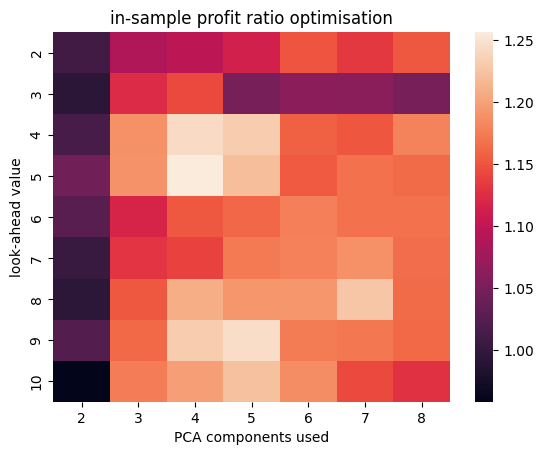

In [66]:
optimisation_matrix = np.array(prs_pos).reshape((look_ahead_vals.size, npca_vals.size))

sns.heatmap(optimisation_matrix, xticklabels=npca_vals, yticklabels=look_ahead_vals)
plt.xlabel("PCA components used")
plt.ylabel("look-ahead value")
plt.title("in-sample profit ratio optimisation")

Here the profit ratios are the average profit ratio across all validation windows - the model shows robust perfrormance under a wide number of parameters.

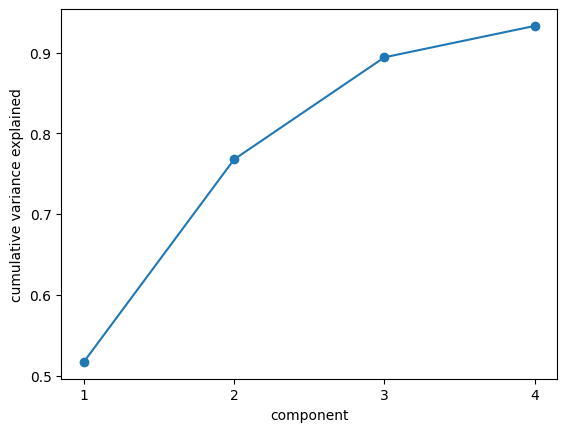

In [67]:
eva = pca.explained_variance_ratio_

plt.plot(np.arange(1,eva.size+1), np.cumsum(eva), "o-")
plt.xlabel("component")
plt.ylabel("cumulative variance explained")
plt.xticks(np.arange(1,eva.size+1));

We can see that the majority of variance is explained by the first four components. The fact that the first principal components explains 84% of all variance suggests that some extra preprocessing could be done.

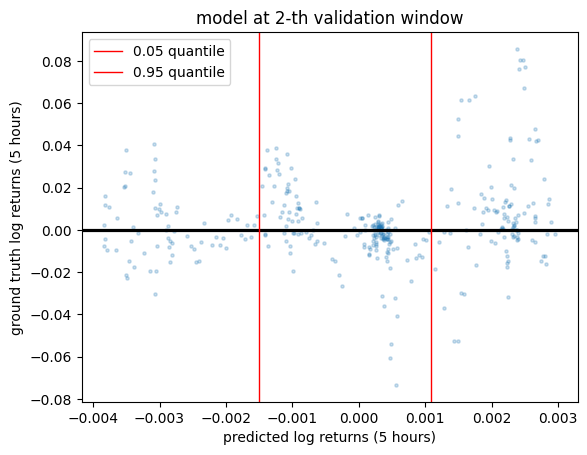

In [14]:
k = 2

y_pred_curr = y_pred[:][k]
y_true_curr = y[:][k]
up_q, low_q = optimisation_dict["subqs"][best_idx_pos][k]

plt.plot(y_pred_curr,y_true_curr, "o", ms=2.3, alpha=0.23)

plt.axhline(y=0, color="k", lw=2.3)

for q, qval in zip([low_q, up_q], ["0.05", "0.95"]):
    plt.axvline(x=q, color="r", lw=1, label=f"{qval} quantile")

plt.xlabel(f"predicted log returns ({N_best} hours)")
plt.ylabel(f"ground truth log returns ({N_best} hours)")
plt.title(f"model at {k}-th validation window")
plt.legend()

We can see that the in sample performance reveals an interesting feature. While the model does not generate useful predictions a lot of the times, at extreme values (namely 0.05 and 0.95 quantiles), the model predicts 

* long position if model prediction above 0.95 quantile
* short position if model prediction below 0.05 quantile
* We apply a moving average with window of N - this is a fractional signal that allows us to rebalance when new information comes in.


profit factor: 1.3387353128966497, sharpe annualised: 3.6999725143867717


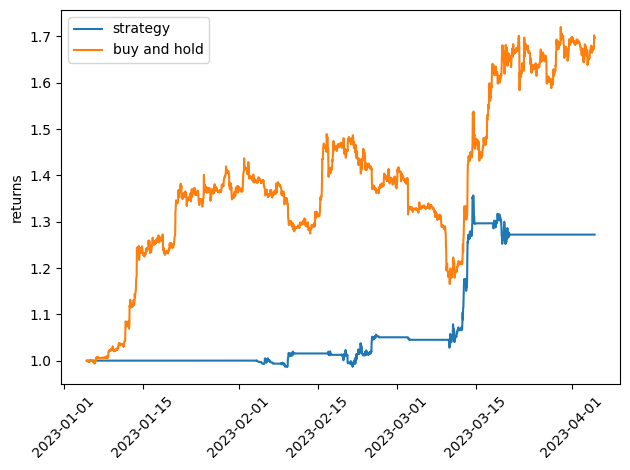

In [ ]:


strat_ret, in_sample_pr, sharpe = utils.compute_returns(best_signal, df_in_sample["log_ret"], cost=cost)

in_sample_sharpe_annualised = sharpe * np.sqrt(365 * 24)

plt.plot(df_in_sample["time"], np.exp(np.nancumsum(strat_ret)), label="strategy")
plt.plot(df_in_sample["time"], np.exp(np.nancumsum(df_in_sample["log_ret"])), label="buy and hold")
plt.ylabel("returns")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()


print(f"profit factor: {in_sample_pr}, sharpe annualised: { in_sample_sharpe_annualised }")


The strategy we optimised in-sample does not beat buy and hold, however it still offers a better Sharpe ratio.

<Axes: >

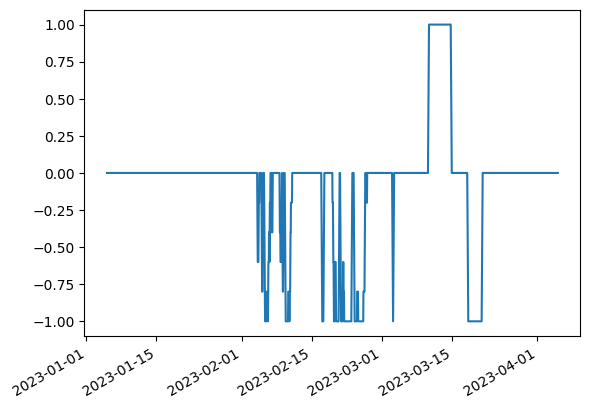

In [17]:
best_signal.plot()

Next, we want to verify that the optimisation we performed was not due to randomness.

### 2. In-Sample MC permutation test

Under the null hypothesis, the in-sample optimisation found a good strategy due to pure chance. By employing a Monte-Carlo permutation test, we can collect evidence that can confirm or deny the null hypothesis. We achieve this by generating permutations of the original signal and optimising our strategy in sample. If we observe a significant amount of strategies that outperform our optimisation, then we know our in-sample optimisation was due to luck and there is no point in walking-forward the model.

Note that the approach we employ here preserves the statistical properties of the original data. However, it does not take into account effects like volatility clustering, so this test will be overly optimistic for strategies that explore volatility clustering.

<Axes: >

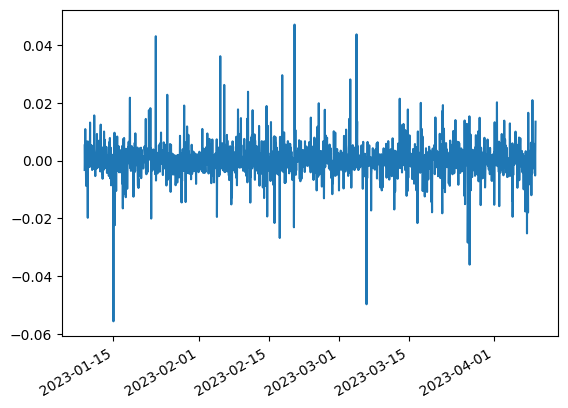

In [89]:
df_mc = df.iloc[:len(df_in_sample) + 101].copy()

def get_simulation(seed:int|None=None) -> pd.DataFrame:

    surrogate_prices = mcps.permute_close_prices(df_mc, seed=seed)

    surrogate_returns = np.log(surrogate_prices).diff()

    surrogate_returns_df = pd.DataFrame({
        "time": df_mc["time"],
        "close": surrogate_prices,
        "log_ret": surrogate_returns
    })

    surrogate_returns_df = utils.add_rsis(surrogate_returns_df, index_windwos_rsi)
    surrogate_returns_df = utils.add_mas(surrogate_returns_df, index_windwos_mas)

    surrogate_returns_df = surrogate_returns_df.dropna().reset_index(drop=True)
    surrogate_returns_df.index = surrogate_returns_df["time"].values

    return surrogate_returns_df

surrogate_returns_df = get_simulation(seed=0)

surrogate_returns_df["log_ret"].plot()



In [90]:
real_log_ret = np.log(df_in_sample['close']).diff()
permuted_log_ret = np.log(surrogate_returns_df["close"]).diff()


print(f"Mean - data : {real_log_ret.mean():.5f} permutation: {(permuted_log_ret).mean():.5f}")
print(f"Stdd - data : {real_log_ret.std():.5f} permutation: {(permuted_log_ret).std():.5f}")
print(f"Skew - data : {real_log_ret.skew():.5f} permutation: {(permuted_log_ret).skew():.5f}")
print(f"Kurt - data : {real_log_ret.kurt():.5f} permutation: {(permuted_log_ret).kurt():.5f}")



Mean - data : 0.00025 permutation: 0.00021
Stdd - data : 0.00576 permutation: 0.00555
Skew - data : 0.20409 permutation: -0.04686
Kurt - data : 17.02409 permutation: 18.09196


In [ ]:
real_sig = best_signal.values 
n = len(real_sig)
turnover_real = np.sum(np.abs(real_sig[1:] - real_sig[:-1]))

# mc_pr, mc_sharpe, mc_returns = [], [], []
mc_pr = []

n_samples = 500

for seed in range(n_samples):

    _mc_sim = get_simulation(seed=seed)

    results_mc = Parallel(n_jobs=-1)(  
        delayed(run_single_optimisation)(_mc_sim, N, npca, time_val)
        for N, npca, time_val in param_combinations
    )


    _mc_optimisation_dict = {
        "sharpe_validate": [],
        "profit_ratio_validate": [],
        "strategy_returns": [],
        "model_outputs": [],
        "pr_distro": [],

    }


    for res in results_mc:
        if res is not None:
            for k in _mc_optimisation_dict:
                _mc_optimisation_dict[k].append(res[k])


    _mc_prs  = [np.nanmean(pr) for pr in _mc_optimisation_dict["pr_distro"]]
    _mc_best_idx = int(np.nanargmax(_mc_prs))
    
    _, _, _, y_pred_mc, _ = _mc_optimisation_dict["model_outputs"][_mc_best_idx]
    
    y_pred_mc = np.concatenate(y_pred_mc)
    full_sig_mc = np.zeros(len(_mc_sim))
    y_mc = y_pred_mc
    ranks = np.argsort(np.argsort(y_mc))
    real_sorted = np.sort(real_sig)
    sig_mc = real_sorted[ranks]

    warmup_len = len(_mc_sim) - len(y_pred_mc)
    full_sig_mc[warmup_len:] = sig_mc

    full_sig_mc = pd.Series(full_sig_mc)
    # compute with costs
    mc_ret, pr, sharpe = utils.compute_returns(full_sig_mc, _mc_sim["log_ret"], cost=0.001)


    # pr = _mc_prs[_mc_best_idx]
    # sharpe = _mc_optimisation_dict["best_sh"]
    # mc_ret = _mc_optimisation_dict["strategy_returns"][best_idx]

    mc_pr.append(pr)


mc_pr = np.array(mc_pr)



In [63]:
import pickle

with open('mc_results_0_500.pickle', 'rb') as handle:
    mc_results_dict = pickle.load(handle)

mc_pr = mc_results_dict["mc_pr"]
mc_sharpe = mc_results_dict["mc_sharpe"]

n_samples = 500

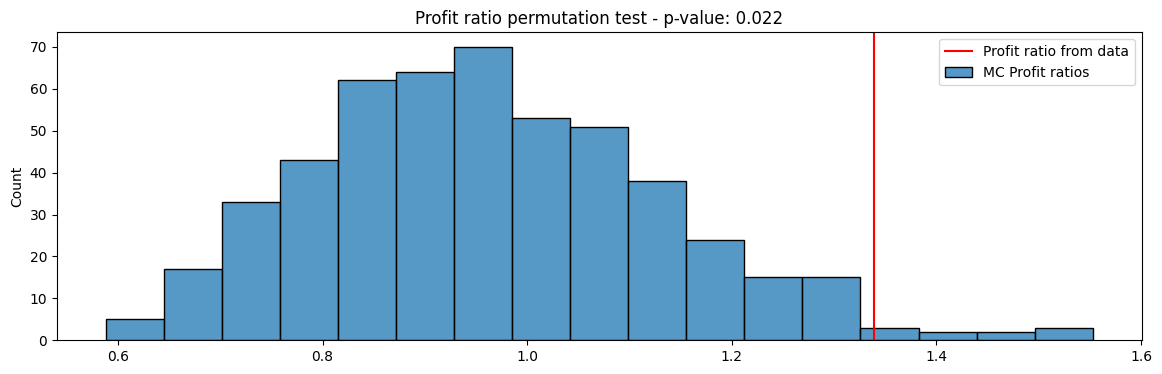

In [64]:
fig, axs = plt.subplots(figsize=(14,4))


p_value_pr = (mc_pr[mc_pr>in_sample_pr].size + 1)/(n_samples+1)
# p_value_sharpe = (mc_sharpe[mc_sharpe>in_sample_sharpe_annualised].size + 1)/(n_samples+1)

sns.histplot(mc_pr, ax =axs, label="MC Profit ratios")
axs.axvline(x=in_sample_pr, color="r", label="Profit ratio from data")
axs.set_title(f"Profit ratio permutation test - p-value: {p_value_pr:.3f}")
axs.legend()



We used the MC permutation test to compute a quasi p-value of $0.022$, suggesting that the probability of a random strategy performing just as well is around $2\%$.

### 3. Walking Forward

We can now walk-forward the model to see the performance in real time conditions. This is a nested walk-forward loop - we optimise for number of PCA components

In [91]:
chop = pd.DateOffset(months=6)

_mask =  (df.index < df.index[0] + chop)
df2 = df.loc[_mask].copy()


wf_signal, y_pred_all, y_true_all = learn.walk_forward_parallel(
    df2,
    look_ahead_vals,
    npca_vals,
    lookback_vals=[40 * 24], 
    optimisation_period=60,
    test_period=5,
    vali_split=1/4,
    cost=cost,
    n_jobs=12,
)


profit ratio: 1.1003533505342138, annualised sharp ratio: 1.2824988176797756


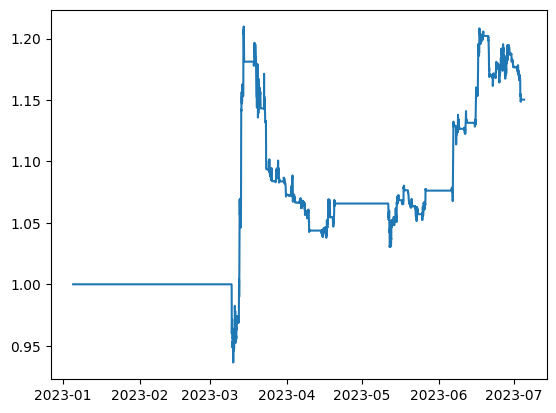

In [97]:

wf_return, wf_profit_ratio, wf_sharpe = utils.compute_returns(wf_signal, df2["log_ret"], cost=0.001)

print(f"profit ratio: {wf_profit_ratio}, annualised sharp ratio: {wf_sharpe* np.sqrt(24*365)}")
plt.plot(df2.index, np.exp(np.nancumsum(wf_return)))


<Axes: >

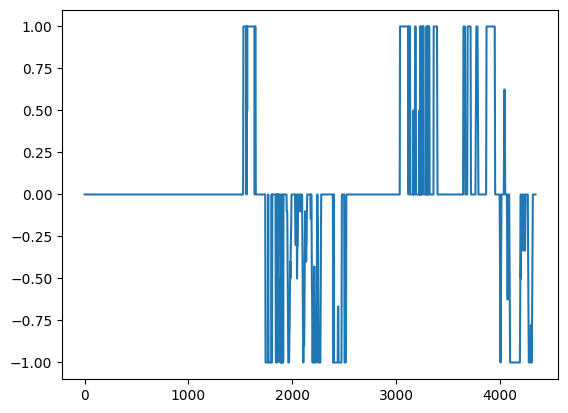

In [94]:
wf_signal.plot()

We can see that the walk-forward validation suggests positive results. While the strategy is not amazing - there are prediods of obvious underperformance. However, there is still a lot of room for optimisation. The quantile values can be added as hyperparameters, etc. The next steps are:
 * Walk-forward MC permutation test. This will confirm if the out of sample result we obtained is due to our optimisation being lucky in this historic period.
 * Bayesian optimisation. As we add more parameters, everything slows down.
 * Optimise my code. It is really slow.